# Preparation

## Import packages

### Import Python packages

In [70]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
from importlib import reload
import json
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from src.extended_anndata import *
from src.ryp import r, to_r, set_config
import src.df_accessors

### Import R packages

In [44]:
r(
"""
options(warn=-1)
library(readr)
library(ggplot2)
library(magrittr)
library(dplyr)
library(tidyr)
library(ggvenn)

library(msigdbr)
library(fgsea)
library(stringr)
"""
)

## Load data

In [66]:
adata = anndata.read_h5ad("results/preprocessed_adata_three.h5ad")
glm_results = adata.uns["simple"]

In [4]:
with open("data/mappings/prop_names.json") as f:
    prop_names = json.load(f)

## Define helper functions

In [ ]:
def intersect_lists(lists):
    if isinstance(lists, dict):
        lists = lists.values()
    return set.intersection(*map(set, lists))

def union_lists(lists):
    if isinstance(lists, dict):
        lists = lists.values()
    return set.union(*map(set, lists))

def get_sig_introns_dict(glm_results, predictor_list, VGIC_only):
    '''
    Given a list of predictors, return a dictionary of significant introns for each predictor
    '''
    return {subclass_name: glm_results.glm.rank_introns_by_n_sig_corr(subclass_name, VGIC_only, True).index.to_list() for subclass_name in predictor_list}

def plot_ggvenn(glm_results, predictor_list, VGIC_only):
    '''
    Given a list of predictors, plot the venn diagram of significant introns for each predictor
    '''
    my_dict = get_sig_introns_dict(glm_results, predictor_list, VGIC_only)
    to_r(my_dict, "my_dict")
    r("ggvenn(my_dict)")

# Venn Diagrams

The intersrction between unions of subclass-associated and ephys-associated splice junctions

null device 
          1 


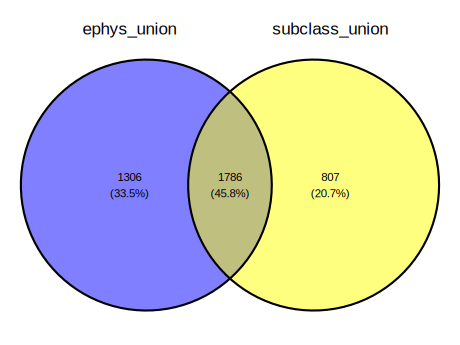

In [6]:
VGIC_only = False
subclass_list = ["Vip", "Sst", "Pvalb", "Lamp5", "Sncg", "Serpinf1"]

ephys_union = glm_results.glm.rank_introns_by_n_sig_corr("ephys_prop", VGIC_only=VGIC_only, sig_only=True).index.to_list()
subclass_union = list(union_lists(get_sig_introns_dict(glm_results, subclass_list, VGIC_only)))
my_dict = {"ephys_union": ephys_union, "subclass_union": subclass_union}
to_r(my_dict, "my_dict")
r("ggvenn(my_dict)")

The intersection between splice junction predicted by each subclass and union of ephys-assocaited splice junctions

null device 
          1 


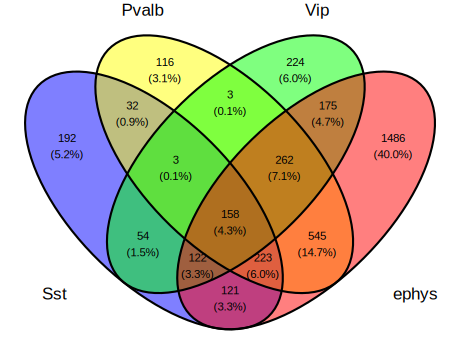

In [9]:
VGIC_only = False

my_dict = get_sig_introns_dict(glm_results, ["Sst", "Pvalb", "Vip"], VGIC_only=VGIC_only)
ephys_union = glm_results.glm.rank_introns_by_n_sig_corr("ephys_prop", VGIC_only=VGIC_only, sig_only=True).index.to_list()
my_dict["ephys"] = ephys_union

to_r(my_dict, "my_dict")
r("ggvenn(my_dict)")

null device 
          1 


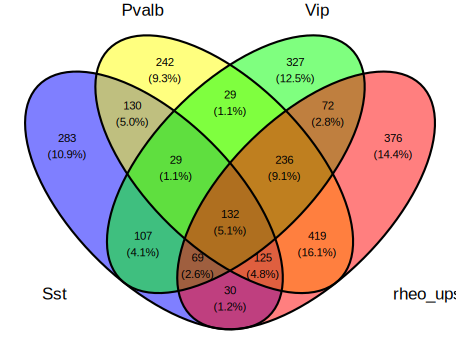

In [10]:
VGIC_only = False

subclass_list = ['Sst', 'Pvalb', 'Vip', 'rheo_upstroke_downstroke_ratio']
plot_ggvenn(glm_results, subclass_list, VGIC_only=VGIC_only)

# Proportions of sig genes that are ion channels

In [69]:
ephys_props = pd.read_csv("data/ephys_data_sc.csv", index_col = 0).columns
n_sig_gene_in_VGIC = [len(glm_results.select_dtypes(include=[np.number]).glm.get_sig_gene_list(predictor, VGIC_only=True)) for predictor in glm_results.columns]
n_sig_gene = [len(glm_results.glm.get_sig_gene_list(predictor, VGIC_only=False)) for predictor in glm_results.columns]

null device 
          1 


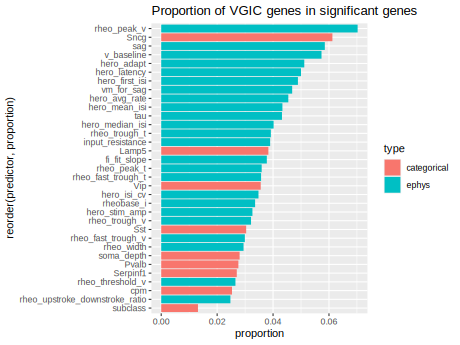

In [34]:
VGIC_prop = pd.Series((np.array(n_sig_gene_in_VGIC) / np.array(n_sig_gene)), index=glm_results.columns, name="proportion")\
    .to_frame()\
    .assign(type = lambda x: np.where(x.index.isin(ephys_props), "ephys", "categorical"))
to_r(VGIC_prop, "VGIC_prop")
r(
"""
VGIC_prop %>% 
  as_tibble(rownames = "predictor") %>% 
  mutate(type = as.factor(type)) %>% 
  ggplot(aes(x = proportion, y = reorder(predictor, proportion), fill = type)) +
    geom_bar(stat = "identity") +
    ggtitle("Proportion of VGIC genes in significant genes")
"""
  )

<Figure size 640x480 with 0 Axes>

null device 
          1 


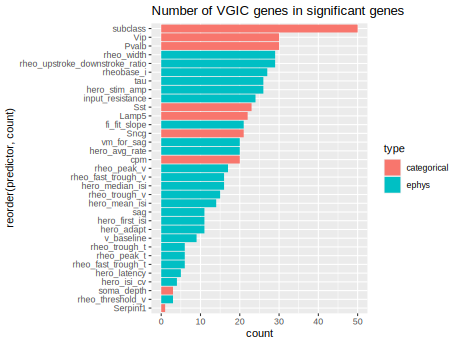

In [67]:
VGIC_count = pd.Series(n_sig_gene_in_VGIC, index = glm_results.columns, name = "count")\
    .to_frame()\
    .assign(type = lambda x: np.where(x.index.isin(ephys_props), "ephys", "categorical"))
to_r(VGIC_count, "VGIC_count")
r(
"""
VGIC_count %>% 
  as_tibble(rownames = "predictor") %>% 
  mutate(type = as.factor(type)) %>% 
  ggplot(aes(x = count, y = reorder(predictor, count), fill = type)) +
    geom_bar(stat = "identity") +
    ggtitle("Number of VGIC genes in significant genes")
"""
  )
plt.savefig("novel_VGIC_count.png")


In [ ]:
subclass_individually = set(src.get_sig_gene_list(glm_results, "Vip"))\
    .union(*[set(src.get_sig_gene_list(glm_results, subclass_name)) for subclass_name in ["Sst", "Pvalb", "Sncg", "Serpinf1"]])
subclass_individually = list(subclass_individually)
to_r(subclass_individually, "subclass_individually")
to_r(src.get_sig_gene_list(glm_results, "subclass"), "subclass")

null device 
          1 


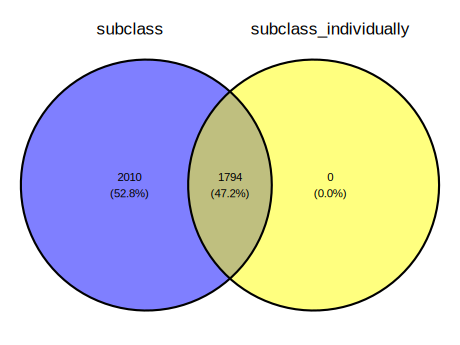

In [ ]:
r(
"""
a <- list(
    subclass = subclass %>% unlist(),
    subclass_individually = subclass_individually %>% unlist())
ggvenn(a)
"""
)

# Number sig clusters that include at least one novel splice site

In [46]:
adata = anndata.read_h5ad("results/preprocessed_adata_three.h5ad")
novel_dict = adata.var\
    .assign(annotation = lambda x: x.annotation.apply({0 : True, 1 : False}.get))\
    .groupby("intron_group")["annotation"].any().to_dict()
temp = glm_results\
    .applymap(lambda x: x < 0.05)\
    .assign(annotation = lambda x: x.index.map(novel_dict))\
    .groupby("annotation")\
    .sum().T\
    .rename(columns = {True : "novel", False : "known"})

/var/folders/dp/78jd5ms973g9m5_9dgvklzxm0000gn/T/ipykernel_85851/3013932588.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("intron_group")["annotation"].any().to_dict()
/var/folders/dp/78jd5ms973g9m5_9dgvklzxm0000gn/T/ipykernel_85851/3013932588.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: x < 0.05)\


In [47]:
rows_to_remove = ['Sst', 'Pvalb', 'Vip', 'Lamp5', 'Sncg', 'Serpinf1', 'subclass', 'soma_depth', 'cpm']
temp = temp.drop(rows_to_remove)
temp.index = temp.index.map(prop_names)

null device 
          1 


Saving 8 x 4.8 in image


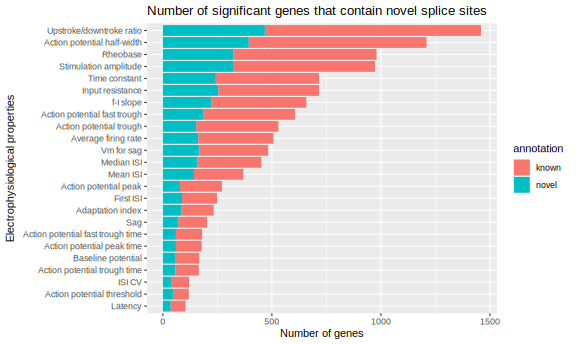

In [53]:
set_config(plot_width=8, plot_height=4.8)
to_r(temp, "temp")
r(
"""
temp %>%
    as_tibble(rownames = "predictor") %>%
    pivot_longer(cols = c("novel", "known"), names_to = "annotation", values_to = "n_sig") %>%
    ggplot(aes(x = n_sig, y = reorder(predictor, n_sig), fill = annotation)) +
        geom_bar(stat = "identity") +
        ggtitle("Number of significant genes that contain novel splice sites") +
        xlab("Number of genes") +
        ylab("Electrophysiological properties")
ggsave("proc/figures/novel_VGIC_count.png")        
"""
)
# plt.savefig("proc/figures/novel_VGIC_count.png")


# Heatmap

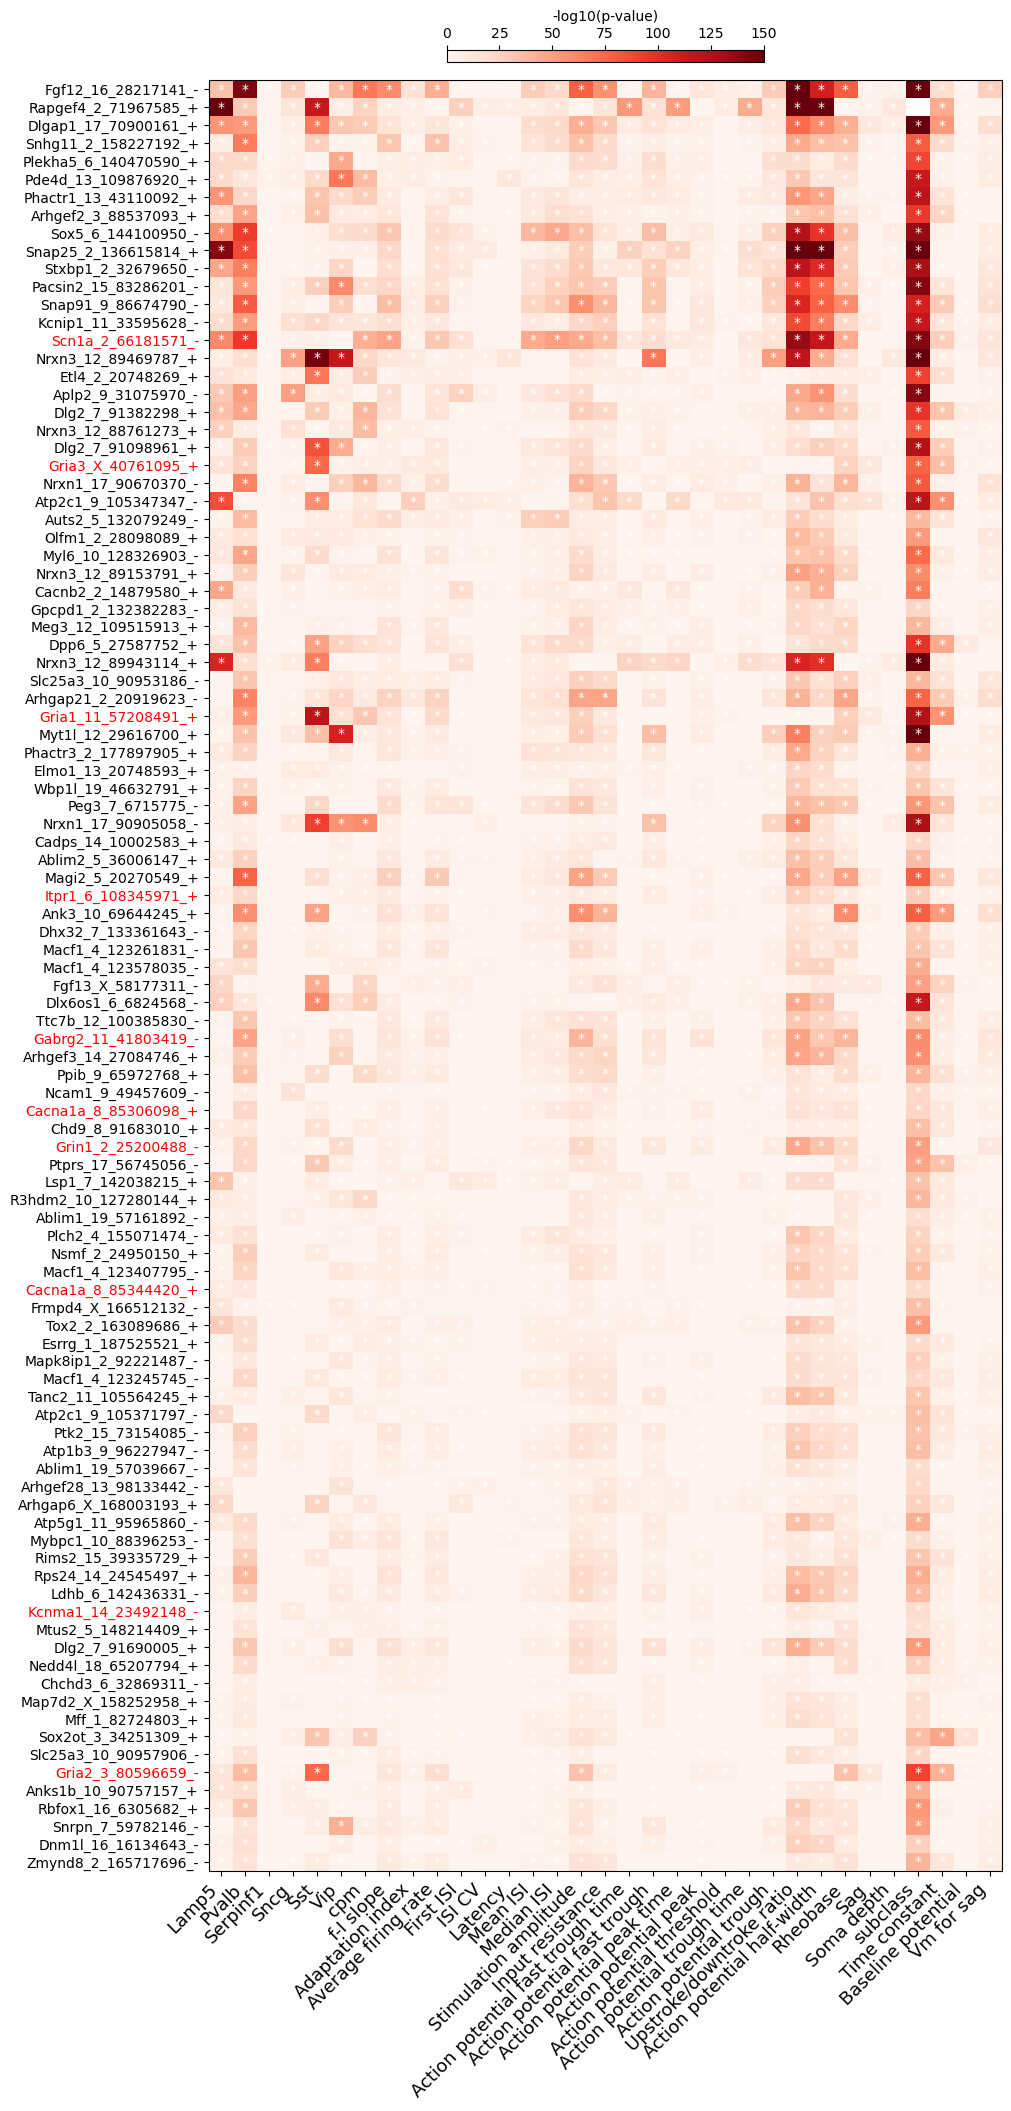

In [78]:
glm_results = src.get_glm_results("proc/scquint/three/simple")
temp = glm_results.glm.rank_introns_by_n_sig_corr(rank_by="all", VGIC_only=False, sig_only=True)
temp.glm.plot_heatmap(top=100)

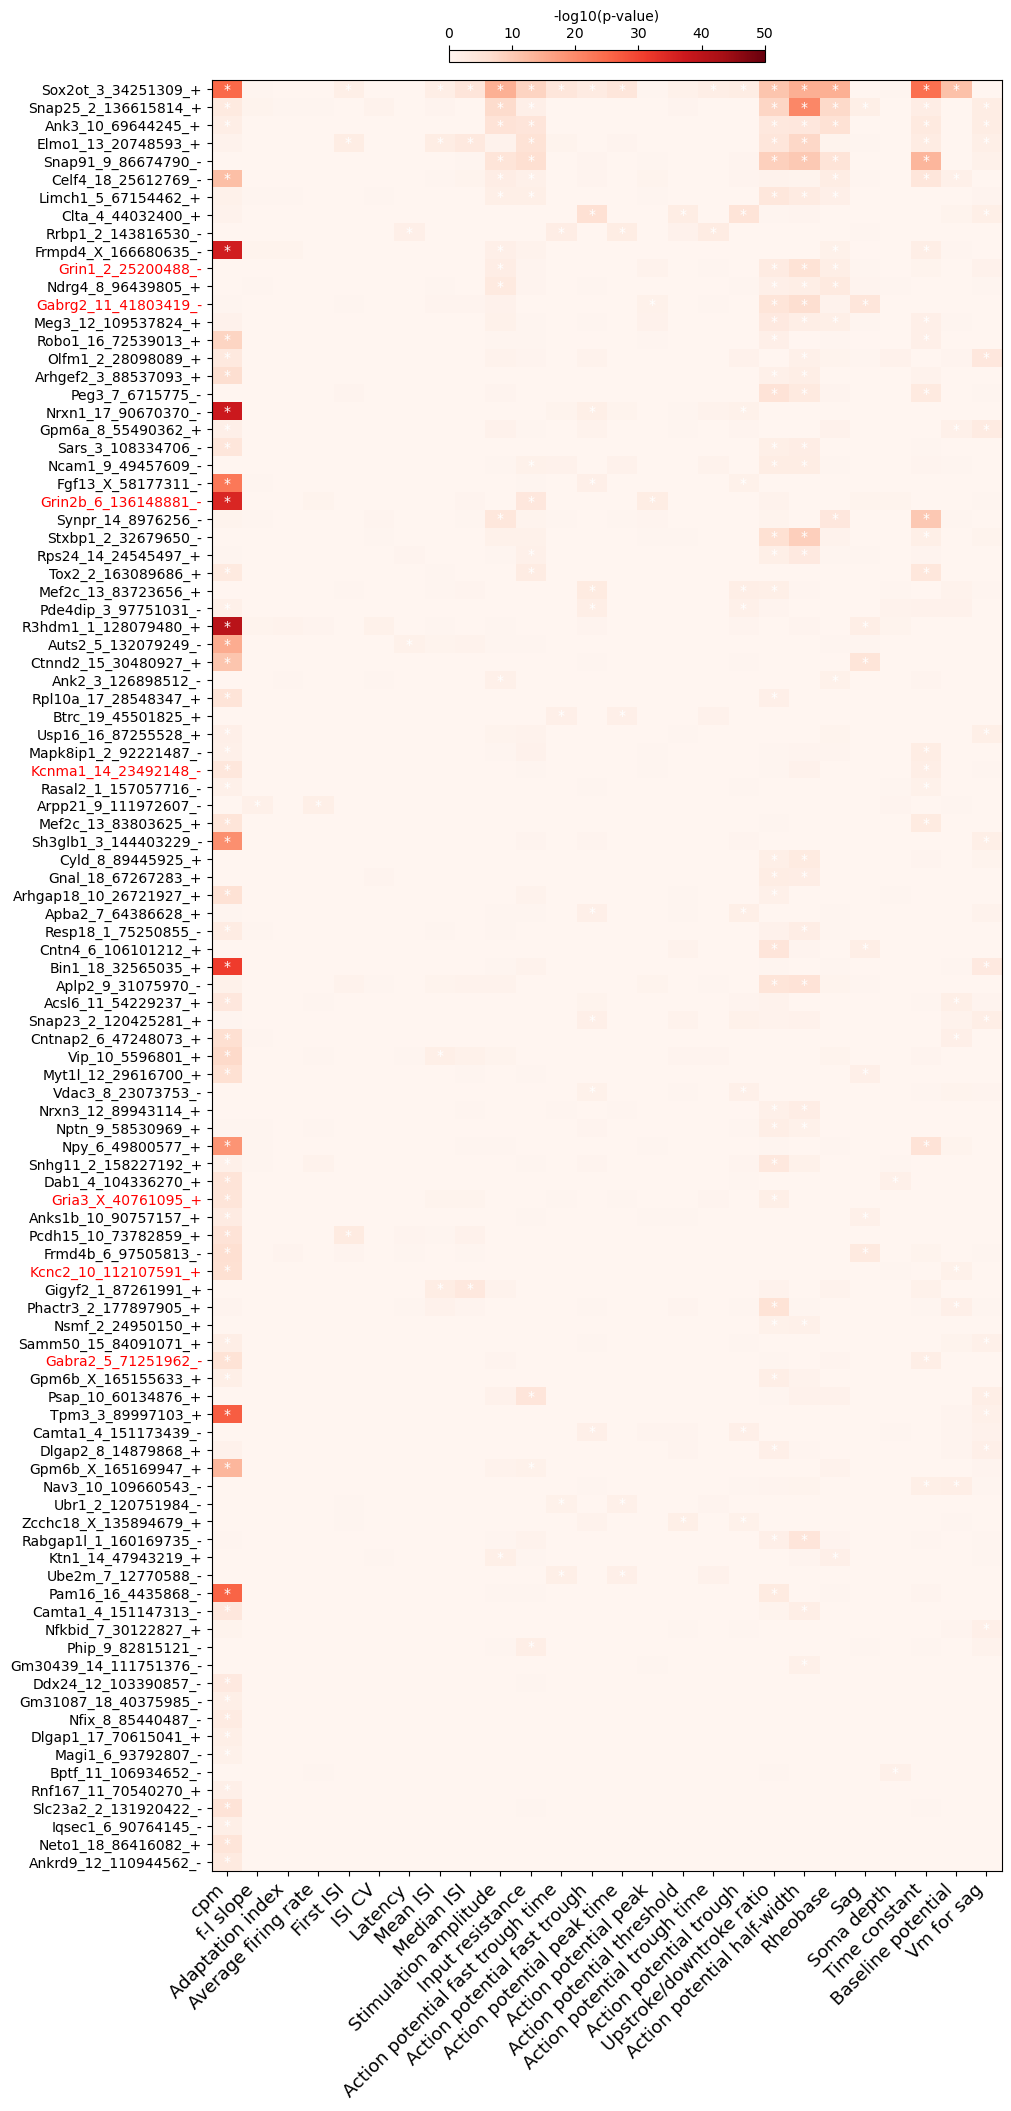

In [81]:
glm_results = src.get_glm_results("proc/scquint/three/multiple")
temp = glm_results.glm.rank_introns_by_n_sig_corr(rank_by="all", VGIC_only=False, sig_only=True)
temp.glm.plot_heatmap(top=100, vmax=50)

# Gene expression

In [46]:
from src.extended_anndata import *

In [58]:
ephys_props = pd.read_csv("data/ephys_data_sc.csv", index_col = 0).columns
adata = ExtendedAnnData(adata)
adata = adata.add_predictors()

Removing cells with more than 6 missing ephys properties
Imputing the rest of the missing ephys values with mean


/Users/xunuo/Library/CloudStorage/OneDrive-UniversityofToronto/projects/patch_seq_spl/src/extended_anndata.py:90: ImplicitModificationWarning: Setting element `.obsm['predictors']` of view, initializing view as actual.
  


In [55]:
adata.uns["simple"]["gene_name"] = adata.uns["simple"]\
    .reset_index()\
    ["event_name"]\
    .str.split("_", expand = True)\
    .iloc[:, 0].values

No relationship between mean cpm of a gene and the *maximum* number of ephys props associated with one of its intron groups

<Axes: xlabel='mean_cpm', ylabel='n_sig'>

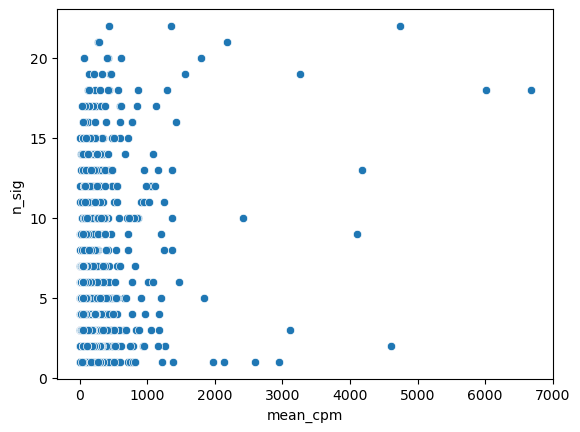

In [59]:
pd.concat([adata.uns["simple"]["gene_name"], adata.uns["simple"].loc[:, ephys_props].apply(lambda x: (x < 0.05)).sum(axis = 1)], axis=1)\
    .rename(columns = {0: "n_sig"})\
    .sort_values(by=["gene_name", "n_sig"], ascending=[True, False])\
    .groupby("gene_name").first().reset_index()\
    .query("n_sig > 0")\
    .pipe(
        pd.merge, 
        adata.obsm["predictors"].select_dtypes(include=[np.number]).T.mean(axis=1).to_frame(), 
        left_on = "gene_name", right_index = True, how = "left")\
    .rename(columns = {0: "mean_cpm"})\
    .pipe(sns.scatterplot, x = "mean_cpm", y = "n_sig")

No relationship between mean cpm of a gene and the *mean* number of ephys props associated with one of its intron groups

<Axes: xlabel='mean_cpm', ylabel='n_sig'>

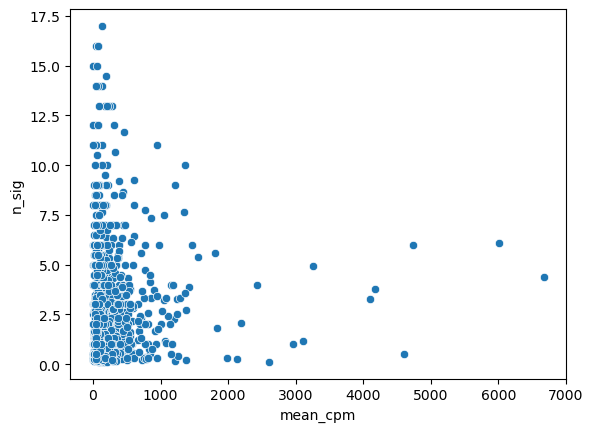

In [60]:
pd.concat([adata.uns["simple"]["gene_name"], adata.uns["simple"].loc[:, ephys_props].apply(lambda x: (x < 0.05)).sum(axis = 1)], axis=1)\
    .rename(columns = {0: "n_sig"})\
    .sort_values(by=["gene_name", "n_sig"], ascending=[True, False])\
    .groupby("gene_name").mean().reset_index()\
    .query("n_sig > 0")\
    .pipe(
        pd.merge, 
        adata.obsm["predictors"].select_dtypes(include=[np.number]).T.mean(axis=1).to_frame(), 
        left_on = "gene_name", right_index = True, how = "left")\
    .rename(columns = {0: "mean_cpm"})\
    .pipe(sns.scatterplot, x = "mean_cpm", y = "n_sig")

# Test

In [72]:
ephys_prop_df = pd.read_csv("data/ephys_data_sc.csv", index_col = 0)

/var/folders/dp/78jd5ms973g9m5_9dgvklzxm0000gn/T/ipykernel_63087/2325077169.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


[Text(0, 0, 'v_baseline'),
 Text(1, 0, 'rheobase_i'),
 Text(2, 0, 'fi_fit_slope'),
 Text(3, 0, 'sag'),
 Text(4, 0, 'vm_for_sag'),
 Text(5, 0, 'input_resistance'),
 Text(6, 0, 'tau'),
 Text(7, 0, 'hero_adapt'),
 Text(8, 0, 'hero_avg_rate'),
 Text(9, 0, 'hero_first_isi'),
 Text(10, 0, 'hero_isi_cv'),
 Text(11, 0, 'hero_latency'),
 Text(12, 0, 'hero_mean_isi'),
 Text(13, 0, 'hero_median_isi'),
 Text(14, 0, 'hero_stim_amp'),
 Text(15, 0, 'rheo_threshold_v'),
 Text(16, 0, 'rheo_trough_v'),
 Text(17, 0, 'rheo_fast_trough_v'),
 Text(18, 0, 'rheo_width'),
 Text(19, 0, 'rheo_upstroke_downstroke_ratio'),
 Text(20, 0, 'rheo_peak_t'),
 Text(21, 0, 'rheo_fast_trough_t'),
 Text(22, 0, 'rheo_trough_t'),
 Text(23, 0, 'rheo_peak_v')]

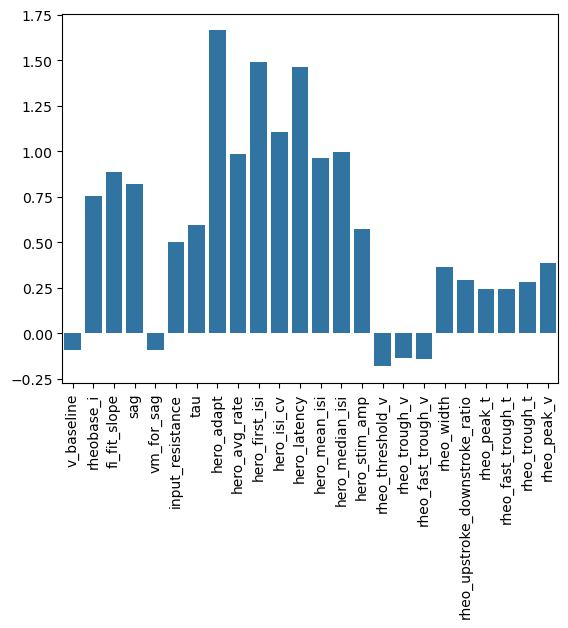

In [79]:
fig, ax = plt.subplots()

ephys_prop_df.apply(lambda x: x.std() / x.mean(), axis = 0)\
    .pipe(sns.barplot, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)